<a href="https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/FPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding frequent patterns in transactional databases using FP-growth

This tutorial has two parts. In the first part, we describe the basic approach to find frequent patterns in a transactional database using the FP-growth algorithm. In the final part, we describe an advanced approach, where we evaluate the FP-growth algorithm on a dataset at different *minimum support* threshold values.

***

## Prerequisites:

1. Installing the PAMI library

In [1]:
!pip install pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=5d6044ae41cd05fb9d3014886fec08b2b3960f5ddf943f8e15cc9c217f373ab0
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3312 sha256=bca883ad885337be7ad95f450444d73b27f37fda4acde7225168de4d3ce07d05
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4752 sha256=e90ff713142482ca3f23d52b504f5bfd22d8900f8f44b6d67adf10210490b854
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully

2. Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv #download a sample transactional database

--2023-07-22 02:33:56--  https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4019277 (3.8M) [text/csv]
Saving to: ‘Transactional_T10I4D100K.csv’

Transactional_T10I4 100%[===================>]   3.83M  1.11MB/s    in 4.7s    

2023-07-22 02:34:02 (840 KB/s) - ‘Transactional_T10I4D100K.csv’ saved [4019277/4019277]



3. Printing few lines of a dataset to know its format.

In [3]:
!head -2 Transactional_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
39	120	124	205	401	581	704	814	825	834


_format:_ every row contains items seperated by a seperator.

__Example:__

item1 item2 item3 item4

item1 item4 item6

***

## Part 1: Finding frequent patterns using FP-growth

### Step 1: Understanding the statistics of a database to choose an appropriate *minimum support* (*minSup*) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.transactionalDatabaseStats as stats

#specify the file name
inputFile = 'Transactional_T10I4D100K.csv'

#initialize the class
obj=stats.transactionalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the items' frequency graph and transaction length's distribution graphs for more information

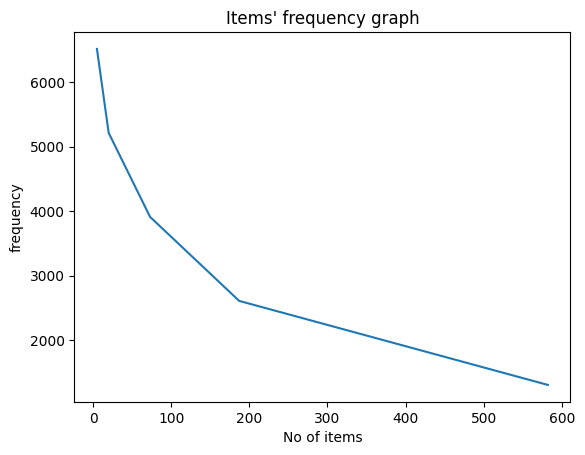

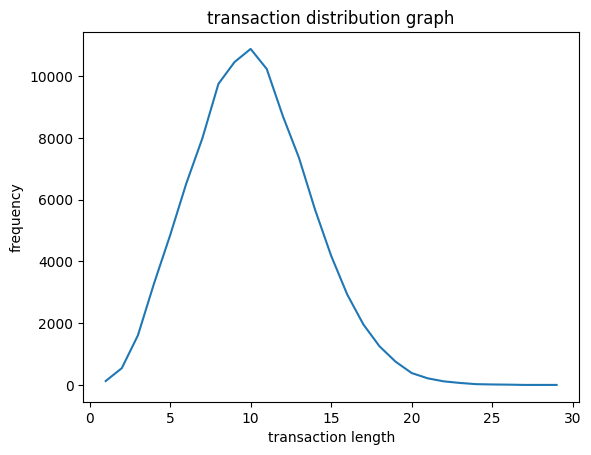

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, 100, 'Items\' frequency graph', 'No of items', 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, 100, 'transaction distribution graph', 'transaction length', 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 300 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minSup=300 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Mining frequent patterns using FP-growth

In [7]:
from PAMI.frequentPattern.basic import FPGrowth  as alg #import the algorithm

obj = alg.FPGrowth(iFile=inputFile, minSup=minSup, sep='\t')    #initialize
obj.startMine()            #start the mining process

obj.save('frequentPatternsAtMinSupCount300.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 4540
Runtime: 17.780718088150024
Memory (RSS): 522670080
Memory (USS): 474681344


### Step 5: Investigating the generated patterns

Open the patterns' file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [8]:
!head frequentPatternsAtMinSupCount300.txt

402:302 
88:303 
807:305 
916:306 
806:308 
301:309 
301	930:301 
301	118:302 
301	362:302 
301	489:306 


The storage format is: _frequentPattern:support_



***

## Part 2: Evaluating the FP-growth algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [9]:
#Import the libraries
from PAMI.frequentPattern.basic import FPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of FP-growth

In [10]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [11]:
for minSupCount in minimumSupportCountList:
    obj = alg.FPGrowth(inputFile, minSup=minSupCount,sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['FP-growth', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm


### Step 4: Print the result

In [12]:
print(result)

   algorithm  minSup  patterns    runtime     memory
0  FP-growth     100     27517  19.564207  553799680
1  FP-growth     150     19119  16.218924  541847552
2  FP-growth     200     13252  15.848265  535810048
3  FP-growth     250      7679  14.742513  532688896
4  FP-growth     300      4540  15.384078  529031168


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

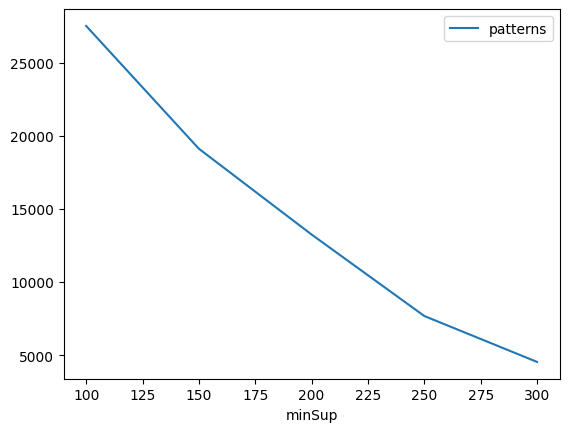

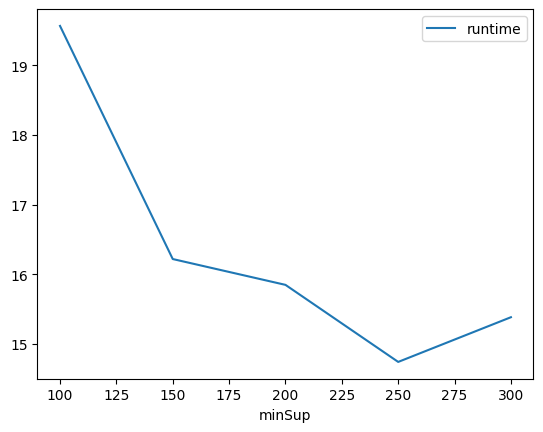

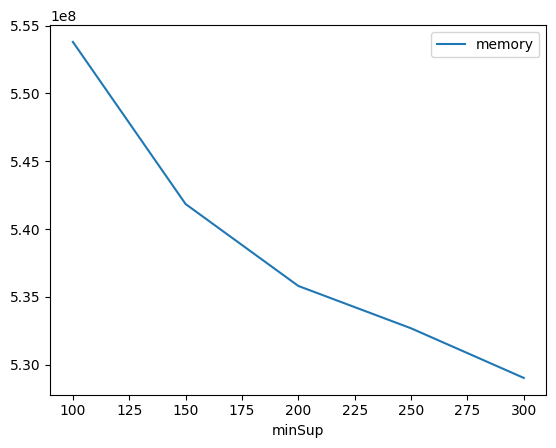

In [14]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib